In [1]:
import mne
#from mne_bids import (BIDSPath, read_raw_bids, print_dir_tree, make_report,
#                      find_matching_paths, get_entity_vals)
import numpy as np
import matplotlib.pyplot as plt
# import scipy as sp
# from scipy import signal
# import seaborn as sns
import pandas as pd
from pathlib import Path
import os
from time import time
from autoreject import AutoReject
from autoreject import get_rejection_threshold

%matplotlib qt

qt.qpa.plugin: Could not find the Qt platform plugin "wayland" in ""


In [3]:
bids_root = r'/home/sivert/Documents/Specialization_project/Datasets/jin2019/study1/raw/eeg/'
path_events = r'/home/sivert/Documents/Specialization_project/Datasets/jin2019/study1/raw/beh/new_events/'

# Print out intiation text with path to the dataset and events
print("\n##### Initiating the preprocessing pipeline for the Jin et al. (2019) dataset. ######")
print(f"Dataset path: {bids_root}")
print(f"Events path: {path_events}\n")

# Print the tree of files
# print_dir_tree(bids_root, max_depth=4)

# Short report print
# print(make_report(bids_root))


# Subject and session to read
subject = 7
session  = 1

# Making N subjects x sessions dataframe
subjects = 30
sessions = 2
# Opprett DataFrame med str som dtype
df_subject_data = pd.DataFrame("", index=range(subjects), columns=range(sessions), dtype=str)
for i in range(subjects):
    for j in range(sessions):
        df_subject_data.iloc[i, j] = f"sub{i+1}_{j+1}"

bids_path = bids_root + df_subject_data.iloc[subject - 1, session - 1] + ".bdf"

# Read the data

print('\n##### Loading data #####')
raw = mne.io.read_raw_bdf(bids_path, preload=True)

# Extracting the channel names
old_ch_names = raw.ch_names

### Temporary channel names ###

# Placeholder names for the old channels
temp_ch_names = ['temp_' + ch for ch in old_ch_names[:-9]]
temp_ch_names.extend(old_ch_names[-9:])
mapping_old_to_temp = dict(zip(old_ch_names, temp_ch_names))


### 64 channel mapping ###

# Create a mapping from 64 to 128 channel names (Realised that i should have done this the other way around)
mapping_64_to_128 ={'Fp1':'C29',
                    'AF7':'C30',
                    'AF3':'C28',
                    'F1':'C25',
                    'F3':'D4',
                    'F5':'D5',
                    'F7':'D7',
                    'FT7':'D8',
                    'FC5':'D10',
                    'FC3':'D12',
                    'FC1':'C24',
                    'C1':'D14',
                    'C3':'D19',
                    'C5':'D21',
                    'T7':'D23',
                    'TP7':'D24',
                    'CP5':'D26',
                    'CP3':'D28',
                    'CP1':'D16',
                    'P1':'A5',
                    'P3':'A7',
                    'P5':'D29',
                    'P7':'D31',
                    'P9':'D32',
                    'PO7':'A10',
                    'PO3':'A17',
                    'O1':'A15',
                    'Iz':'A25',
                    'Oz':'A23',
                    'POz':'A21',
                    'Pz':'A19',
                    'CPz':'A3',
                    'Fpz':'C17',
                    'Fp2':'C16',
                    'AF8':'C8',
                    'AF4':'C15',
                    'AFz':'C19',
                    'Fz':'C21',
                    'F2':'C12',
                    'F4':'C4',
                    'F6':'C5',
                    'F8':'C7',
                    'FT8':'B27',
                    'FC6':'B29',
                    'FC4':'B31',
                    'FC2':'C11',
                    'FCz':'C23',
                    'Cz':'A1',
                    'C2':'B20',
                    'C4':'B22',
                    'C6':'B24',
                    'T8':'B26',
                    'TP8':'B14',
                    'CP6':'B16',
                    'CP4':'B18',
                    'CP2':'B2',
                    'P2':'A32',
                    'P4':'B4',
                    'P6':'B13',
                    'P8':'B11',
                    'P10':'B10',
                    'PO8':'B7',
                    'PO4':'A30',
                    'O2':'A28'}
# Invert the dictionary and add 'temp_'
mapping_128_to_64 = {'temp_' + v: k for k, v in mapping_64_to_128.items()}

### Non-EEG channels ###

# Create a mapping for non-EEG channels
mapping_non_eeg = {'EXG1': 'sacc_EOG1',
                   'EXG2': 'sacc_EOG2',
                   'EXG3': 'blink_EOG1',
                   'EXG4': 'blink_EOG2'}


print("\n##### Renaming and dropping channels #####")

# Original channel names
print("Channels before renaming and dropping:", raw.info['ch_names'])

# Rename the channels in the dataset
raw.rename_channels(mapping_old_to_temp)
raw.rename_channels(mapping_128_to_64)
raw.rename_channels(mapping_non_eeg)

# Verify the new channel names
print("Channels after renaming:", raw.info['ch_names'], '\n')

# Set the channel types for the EXG channels
raw.set_channel_types({
    'sacc_EOG1': 'eog',
    'sacc_EOG2': 'eog',
    'blink_EOG1': 'eog',
    'blink_EOG2': 'eog',
    'EXG5': 'misc',  # Could be a mastoid, set as misc
    'EXG6': 'misc',  # Could be a mastoid, set as misc
    'EXG7': 'misc',  # Could be a mastoid, set as misc
    'EXG8': 'misc'   # Could be a mastoid, set as misc
})

# Identify non-EEG channels
non_eeg_channels = [ch for ch, ch_type in zip(raw.ch_names, raw.get_channel_types()) if ch_type != 'eeg']

# Get a list of the channels you want to retain (the new 64-channel names and the non-EEG channels)
channels_to_keep = list(mapping_64_to_128.keys()) + non_eeg_channels

# Drop the channels not in the 64-channel system
raw.pick(channels_to_keep)

# Verify the new channel set
print("Channels after dropping:", raw.info['ch_names'])
print("Number of channels:", len(raw.info['ch_names']), 'out of 73 (64 EEG + 9 non-EEG) \n')

# Load the BioSemi 128-channel montage
montage = mne.channels.make_standard_montage('biosemi64')
raw.set_montage(montage)
# raw.plot_sensors(show_names=True)

# Plot rådata for å inspisere
# raw.plot(highpass=1)

# Segementing the data into epochs

print("\n##### Finding old events in raw stim data #####")

# create epochs with stimuli channel
events_old = mne.find_events(raw, stim_channel='Status', verbose=False)

# Plot how many times the events repeat
mne.viz.plot_events(events_old, raw.info['sfreq'])

# import the events
def load_new_events(path, subject, session):
    file_name = f'subject-{subject}_session-{session}_events.csv'
    file_path = os.path.join(path, file_name)
    if os.path.exists(file_path):
        df = pd.read_csv(file_path)
        column_names = df.columns.values
        return df.values, column_names
    else:
        raise FileNotFoundError(f"No such file: {file_path}")

print("\n##### Loading new events from probes #####")

# Load the dataframes
new_events, event_info = load_new_events(path_events, subject, session)

def encode_events(events):
    """
    Encode a 2D array of events with 3 integers into a 1D array of encoded integers.
    
    Parameters:
    events (np.ndarray): 2D array of shape (n_events, 3) where each row contains 3 integers.
    
    Returns:
    np.ndarray: 1D array of shape (n_events, 1) with encoded integers.
    """
    return events[:, 0] * 100 + events[:, 1] + events[:, 2]* 10 

def decode_events(encoded_events):
    """
    Decode a 1D array of encoded integers back into a 2D array of events with 3 integers.
    
    Parameters:
    encoded_events (np.ndarray): 1D array of shape (n_events, 1) with encoded integers.
    
    Returns:
    np.ndarray: 2D array of shape (n_events, 3) where each row contains 3 integers.
    """
    events = np.zeros((encoded_events.shape[0], 3), dtype=int)
    events[:, 0] = encoded_events // 100
    events[:, 2] = (encoded_events % 100) // 10
    events[:, 1] = encoded_events % 10
    return events

def decode_event(event_id, event_info=event_info):
    """
    Decode an encoded event ID back into the original event.
    
    Parameters:
    event_id (int): Encoded event ID.
    
    Returns:
    dict: Event as a dict of 3 integers.
    """
    return {event_info[0]: event_id // 100, event_info[1]: event_id % 10, event_info[2]: (event_id % 100) // 10}

# Encode and decode the new events
encoded_new_events = encode_events(new_events)
decoded_new_events = decode_events(encoded_new_events)

# Verify that the decoded events match the original new events
assert np.array_equal(new_events, decoded_new_events), "ERROR: Decoded events do not match the original events"

# Filter events to keep only IDs in range 9–22
filtered_events = events_old[(events_old[:, 2] >= 10) & (events_old[:, 2] <= 21)]

# Verify alignment
assert len(filtered_events) == len(encoded_new_events), "ERROR: Mismatch between filtered events and CSV rows"

# Replace the third column in the filtered events array
filtered_events[:, 2] = encoded_new_events
# Update the event_id dictionary with the new event IDs
event_id = {str(event): event for event in np.unique(filtered_events[:, 2])}

# Create an Info object for plotting (using the original raw data's sampling frequency)
info = mne.create_info(ch_names=['STIM'], sfreq=raw.info['sfreq'], ch_types=['stim'])

# Create a RawArray object for the events
stim_data = np.zeros((1, raw.n_times))  # Create empty data with one channel
for event in filtered_events:
    stim_data[0, event[0]] = event[2]  # Place the encoded event value at the event timepoint

print("\n##### Replacing new stim channel in raw data #####")

# Create a Raw object for the events
raw_events = mne.io.RawArray(stim_data, info)

# Add the events to the raw data
raw.add_channels([raw_events], force_update_info=True)

# Plot the stim channels for visual inspection
#raw.plot(picks='stim')

# Drop the Status channel
raw.drop_channels(['Status'])

# create event id dictionary
event_id = {'probe_off/vs/0/undefined': 0,
            'probe_off/vs/1/OT': 1,
            'probe_off/vs/2/OT': 2,
            'probe_off/vs/3/MW': 3,
            'probe_off/vs/4/undefined': 4,
            'probe_off/vs/5/MW': 5,
            'probe_off/vs/6/undefined': 6,
            'probe_off/sart/0/undefined': 10,
            'probe_off/sart/1/OT': 11,
            'probe_off/sart/2/OT': 12,
            'probe_off/sart/3/MW': 13,
            'probe_off/sart/4/undefined': 14,
            'probe_off/sart/5/MW': 15,
            'probe_off/sart/6/undefined': 16,
            'probe_on/vs/0/undefined': 100,
            'probe_on/vs/1/OT': 101,
            'probe_on/vs/2/OT': 102,
            'probe_on/vs/3/MW': 103,
            'probe_on/vs/4/undefined': 104,
            'probe_on/vs/5/MW': 105,
            'probe_on/vs/6/undefined': 106,
            'probe_on/sart/0/undefined': 110,
            'probe_on/sart/1/OT': 111,
            'probe_on/sart/2/OT': 112,
            'probe_on/sart/3/MW': 113,
            'probe_on/sart/4/undefined': 114,
            'probe_on/sart/5/MW': 115,
            'probe_on/sart/6/undefined': 116}

print("\n##### Finding new events with new stim channel #####")

# Finding new events with new stim channel
events = mne.find_events(raw, stim_channel='STIM', verbose=False)

# Remove unused event ids from the event_id dictionary
unused_event_ids = set(event_id.values()) - set(events[:, 2])
event_id = {k: v for k, v in event_id.items() if v not in unused_event_ids}

# Compare number of events before and after new events
if len(filtered_events) != len(events):
    # Print the difference in number of events
    print(f"WARNING: Number of events have changed from {len(filtered_events)} to {len(events)}")

# Update the second column with the value from the third column of the previous row
events[1:, 1] = events[:-1, 2]  # Shift the third column down by one row

# First row stays zero in the second column
events[0, 1] = 0

# Plot the events
mne.viz.plot_events(events, raw.info['sfreq'], event_id=event_id, verbose=False)

print("\n##### Downsampling #####")

# Downsampling to 128 Hz
raw.resample(sfreq=128, npad="auto", verbose=False)

# Print the new sampling frequency
print(f"New sample frequency: {raw.info['sfreq']} Hz")

print("\n##### Averaging and filtering raw data #####")

preprocessed_data = raw.copy()
# Apply an average reference to the data
preprocessed_data.set_eeg_reference(ref_channels='average', verbose=False)

# Filter out low frequencies
preprocessed_data.filter(l_freq=1, h_freq=None, verbose=False)

# average reference
preprocessed_data.set_eeg_reference(ref_channels='average', verbose=False)

# Verify the new reference
print(preprocessed_data.info['custom_ref_applied'])  # Should be 1 if referencing was applied

# Plot the data
# preprocessed_data.plot()


# Define the event classes
event_classes = {
    'vs/MW': [103, 105],
    'sart/MW': [113, 115],
    'vs/OT': [101, 102],
    'sart/OT': [111, 112]
}

# Define window parameters
tmin = -5  # Start of the window (e.g., x seconds before the event)
tmax = 0   # End of the window (e.g., when the event occurs)

# Create a new event_id dictionary for the classes
class_event_id = {label: idx + 1 for idx, label in enumerate(event_classes.keys())}

# Map the events to the new classes
classified_events = events.copy()
for class_label, event_codes in event_classes.items():
    for code in event_codes:
        classified_events[classified_events[:, 2] == code, 2] = class_event_id[class_label]

print("\n##### Creating epochs for each class #####")

# Create epochs for each class
epochs_classified = mne.Epochs(preprocessed_data, classified_events, event_id=class_event_id, tmin=tmin, tmax=tmax, 
                               baseline=None, preload=True)

epochs_original = epochs_classified.copy()

# Autoreject the bad epochs
print("\n##### Autorejecting bad epochs #####")
ar = AutoReject() ################################                                    REMEMBER TO CITE
epochs_classified, reject_log = ar.fit_transform(epochs_classified, return_log=True)
get_rejection_threshold(epochs_classified)  # Get the rejection threshold dictionary

# Count the number of epochs in each class
epochs_classified_counts = epochs_classified.__len__()
epochs_MW_vs_counts = epochs_classified['vs/MW'].__len__()
epochs_MW_sart_counts = epochs_classified['sart/MW'].__len__()
epochs_OT_vs_counts = epochs_classified['vs/OT'].__len__()
epochs_OT_sart_counts = epochs_classified['sart/OT'].__len__()

# Plot the class balance between sart and vs
fig, ax = plt.subplots()
ax.bar(['MW_vs', 'MW_sart', 'OT_vs', 'OT_sart'], [epochs_MW_vs_counts, epochs_MW_sart_counts, epochs_OT_vs_counts, epochs_OT_sart_counts])
ax.set_ylabel('Number of epochs')
ax.set_title('Class balance')
plt.show()

# Find the ratio of MW vs OT in the data
ratio_vs = epochs_MW_vs_counts / (epochs_classified['vs'].__len__())
ratio_sart = epochs_MW_sart_counts / (epochs_MW_sart_counts + epochs_OT_sart_counts)

print(f"Ratio of MW vs OT in MW vs epochs: {ratio_vs:.2f}")

print(f"Ratio of MW vs OT in MW sart epochs: {ratio_sart:.2f}")

class_imbalanace_range = [0.7, 0.3] # A 7:3 ratio

if ratio_vs > class_imbalanace_range[0] or ratio_vs < class_imbalanace_range[1]:
    print("WARNING: Ratio of MW vs OT in visual search epochs is not within 7:3 or opposite")

if ratio_sart > class_imbalanace_range[0] or ratio_sart < class_imbalanace_range[1]:
    print("WARNING: Ratio of MW vs OT in SART epochs is not within 7:3 or opposite")

if (ratio_vs <= class_imbalanace_range[0]) and (ratio_vs >= class_imbalanace_range[1]):
    # Save epochs
    print("\n##### Saving epochs #####")
    epochs_classified['MW_vs', 'OT_vs'].save('test_epoch.fif')


##### Initiating the preprocessing pipeline for the Jin et al. (2019) dataset. ######
Dataset path: /home/sivert/Documents/Specialization_project/Datasets/jin2019/study1/raw/eeg/
Events path: /home/sivert/Documents/Specialization_project/Datasets/jin2019/study1/raw/beh/new_events/


##### Loading data #####
Extracting EDF parameters from /home/sivert/Documents/Specialization_project/Datasets/jin2019/study1/raw/eeg/sub7_1.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 3183103  =      0.000 ...  6216.998 secs...

##### Renaming and dropping channels #####
Channels before renaming and dropping: ['A1', 'A2', 'A3', 'A4', 'A5', 'A6', 'A7', 'A8', 'A9', 'A10', 'A11', 'A12', 'A13', 'A14', 'A15', 'A16', 'A17', 'A18', 'A19', 'A20', 'A21', 'A22', 'A23', 'A24', 'A25', 'A26', 'A27', 'A28', 'A29', 'A30', 'A31', 'A32', 'B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B9', 'B10', 'B11', 'B12', 'B13', 'B14', 'B15', 'B16', 'B17', 'B18', 'B19', 'B2

/tmp/ipykernel_823127/1937870886.py:140: RuntimeWarning: The unit for channel(s) EXG5, EXG6, EXG7, EXG8 has changed from V to NA.
  raw.set_channel_types({


Channels after dropping: ['Fp1', 'AF7', 'AF3', 'F1', 'F3', 'F5', 'F7', 'FT7', 'FC5', 'FC3', 'FC1', 'C1', 'C3', 'C5', 'T7', 'TP7', 'CP5', 'CP3', 'CP1', 'P1', 'P3', 'P5', 'P7', 'P9', 'PO7', 'PO3', 'O1', 'Iz', 'Oz', 'POz', 'Pz', 'CPz', 'Fpz', 'Fp2', 'AF8', 'AF4', 'AFz', 'Fz', 'F2', 'F4', 'F6', 'F8', 'FT8', 'FC6', 'FC4', 'FC2', 'FCz', 'Cz', 'C2', 'C4', 'C6', 'T8', 'TP8', 'CP6', 'CP4', 'CP2', 'P2', 'P4', 'P6', 'P8', 'P10', 'PO8', 'PO4', 'O2', 'sacc_EOG1', 'sacc_EOG2', 'blink_EOG1', 'blink_EOG2', 'EXG5', 'EXG6', 'EXG7', 'EXG8', 'Status']
Number of channels: 73 out of 73 (64 EEG + 9 non-EEG) 


##### Finding old events in raw stim data #####

##### Loading new events from probes #####

##### Replacing new stim channel in raw data #####
Creating RawArray with float64 data, n_channels=1, n_times=3183104
    Range : 0 ... 3183103 =      0.000 ...  6216.998 secs
Ready.

##### Finding new events with new stim channel #####


/tmp/ipykernel_823127/1937870886.py:329: RuntimeWarning: More events than default colors available. You should pass a list of unique colors.
  mne.viz.plot_events(events, raw.info['sfreq'], event_id=event_id, verbose=False)



##### Downsampling #####
New sample frequency: 128.0 Hz

##### Averaging and filtering raw data #####
1 (FIFFV_MNE_CUSTOM_REF_ON)

##### Creating epochs for each class #####
Not setting metadata
389 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 389 events and 641 original time points ...
288 bad epochs dropped

##### Autorejecting bad epochs #####
Running autoreject on ch_type=eeg


100%|██████████| Creating augmented epochs : 64/64 [00:01<00:00,   56.05it/s]
100%|██████████| Computing thresholds ... : 64/64 [00:30<00:00,    2.09it/s]

































































100%|██████████| Repairing epochs : 101/101 [00:01<00:00,   66.96it/s]





































































































100%|██████████| Repairing epochs : 101/101 [00:02<00:00,   41.27it/s]






















100%|██████████| Fold : 10/10 [00:02<00:00,    3.47it/s]



































































































100%|██████████| Repairing epochs : 101/101 [00:02<00:00,   48.55it/s]






















100%|██████████| Fold : 10/10 [00:03<00:00,    3.09it/s]




































































































100%|██████████| Repairing epochs : 101/101 [00:02<00:00,   41.54it/s]






















100%|██████████|





Estimated consensus=0.70 and n_interpolate=32






































































































100%|██████████| Repairing epochs : 101/101 [00:02<00:00,   41.88it/s]

Dropped 7 epochs: 8, 25, 53, 78, 86, 87, 97


Estimating rejection dictionary for eeg
Estimating rejection dictionary for eog
Ratio of MW vs OT in MW vs epochs: 0.25
Ratio of MW vs OT in MW sart epochs: 0.98


No baseline correction applied


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


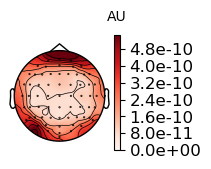

In [22]:
epochs_classified.preload

# Plot the epochs in time-frequency domain
frequencies = np.arange(8, 13, 3)
power = epochs_classified['vs/MW'].compute_tfr(
    "morlet", n_cycles=2, return_itc=False, freqs=frequencies, decim=3, average=True
)
power.plot_topomap()

In [ ]:
epochs_classified['MW_vs', 'OT_vs'].save('test_epoch.fif')

/tmp/ipykernel_820415/3257284922.py:1: RuntimeWarning: This filename (test_epoch.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs_classified['MW_vs', 'OT_vs'].save('test_epoch.fif')


**Plotting epochs and preprocessed data**

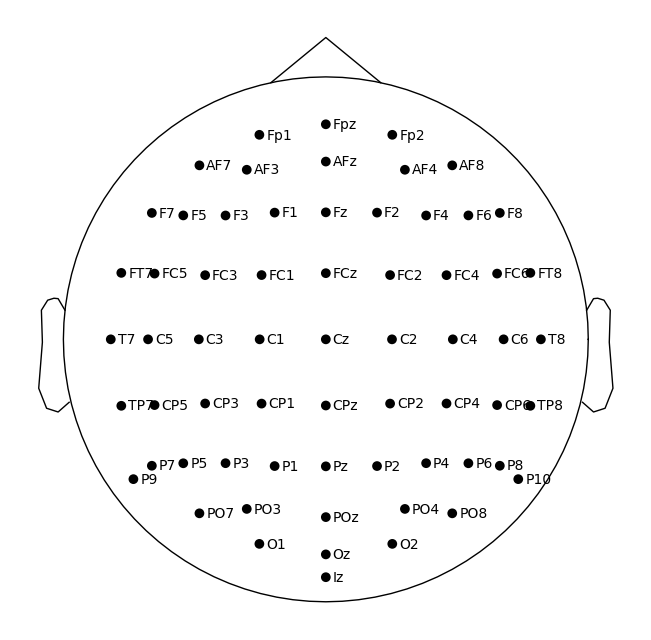

In [ ]:
# plot montage
epochs_classified.plot_sensors(show_names=True)

In [ ]:
# Plot the raw processed data
preprocessed_data.plot()

# Plot the epochs for each class
for class_label in class_event_id.keys():
    try:
        epochs_classified[class_label].plot(title=f"Epochs for {class_label}")
    except:
        print(f"Class {class_label} does not exist in the epochs.")

# plot the average of each class
for class_label in class_event_id.keys():
    try:
        epochs_classified[class_label].average().plot()
    except:
        print(f"Class {class_label} does not exist in the epochs.")

Class MW_sart does not exist in the epochs.
Class MW_sart does not exist in the epochs.


**ICA analysis**

In [7]:

reject = dict(eeg=180e-6)

def run_ica(method, fit_params=None):
    ica = mne.preprocessing.ICA(
        n_components=20,
        method=method,
        fit_params=fit_params,
        max_iter="auto",
        random_state=0,
    )
    t0 = time()
    ica.fit(preprocessed_data, reject=reject)
    fit_time = time() - t0
    title = f"ICA decomposition using {method} (took {fit_time:.1f}s)"
    ica.plot_components(title=title)
    return ica


ica = run_ica("infomax")

Fitting ICA to data using 64 channels (please be patient, this may take a while)
    Rejecting  epoch based on EEG : ['AF7', 'Fp2', 'AF8']
Artifact detected in [0, 256]
    Rejecting  epoch based on EEG : ['Fp1', 'AF7', 'AF3', 'Fpz', 'Fp2', 'AF8', 'AF4']
Artifact detected in [256, 512]
    Rejecting  epoch based on EEG : ['Fp1', 'AF7', 'AF3', 'Fpz', 'Fp2', 'AF8', 'AF4']
Artifact detected in [512, 768]
    Rejecting  epoch based on EEG : ['AF7', 'Fp2', 'AF8']
Artifact detected in [768, 1024]
    Rejecting  epoch based on EEG : ['Fp1', 'AF7', 'AF3', 'T7', 'Fpz', 'Fp2', 'AF8', 'AF4', 'AFz', 'F8']
Artifact detected in [1024, 1280]
    Rejecting  epoch based on EEG : ['Fp1', 'AF7', 'AF3', 'Fpz', 'Fp2', 'AF8', 'AF4', 'T8']
Artifact detected in [1280, 1536]
    Rejecting  epoch based on EEG : ['Fp2', 'AF8']
Artifact detected in [1536, 1792]
    Rejecting  epoch based on EEG : ['Fp2']
Artifact detected in [2560, 2816]
    Rejecting  epoch based on EEG : ['AF7', 'F7', 'Fp2', 'AF8', 'F8']
Artifa

In [ ]:
# Plotting ICA components and their properties
ica.plot_properties(epochs_classified, picks=[0, 1, 6, 9, 17])


    Using multitaper spectrum estimation with 7 DPSS windows
Not setting metadata
94 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
94 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
94 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
94 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
94 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
94 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
94 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
94 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
94 matching events found
No baseline correction applied
0 projection i

[<Figure size 700x600 with 6 Axes>,
 <Figure size 700x600 with 6 Axes>,
 <Figure size 700x600 with 6 Axes>,
 <Figure size 700x600 with 6 Axes>,
 <Figure size 700x600 with 6 Axes>,
 <Figure size 700x600 with 6 Axes>,
 <Figure size 700x600 with 6 Axes>,
 <Figure size 700x600 with 6 Axes>,
 <Figure size 700x600 with 6 Axes>,
 <Figure size 700x600 with 6 Axes>,
 <Figure size 700x600 with 6 Axes>,
 <Figure size 700x600 with 6 Axes>,
 <Figure size 700x600 with 6 Axes>,
 <Figure size 700x600 with 6 Axes>]

Applying ICA to Epochs instance
    Transforming to ICA space (20 components)
    Zeroing out 5 ICA components
    Projecting back using 64 PCA components


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


No baseline correction applied


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


No baseline correction applied
No baseline correction applied
No baseline correction applied
No baseline correction applied
No baseline correction applied


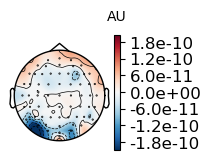

In [27]:
epochs_cleaned = epochs_classified.copy()

ica.exclude = [0, 1, 6, 9, 17] # select components to exclude
ica.apply(epochs_cleaned)

# Plot the epochs in time-frequency domain
frequencies = np.arange(8, 13, 3)

# compute power for each class
power_vs_mw = epochs_classified['vs/MW'].compute_tfr(
    "morlet", n_cycles=2, return_itc=False, freqs=frequencies, decim=3, average=True
)
power_vs_ot = epochs_classified['vs/OT'].compute_tfr(
    "morlet", n_cycles=2, return_itc=False, freqs=frequencies, decim=3, average=True
)
power_sart_mw = epochs_classified['sart/MW'].compute_tfr(
    "morlet", n_cycles=2, return_itc=False, freqs=frequencies, decim=3, average=True
)
power_sart_ot = epochs_classified['sart/OT'].compute_tfr(
    "morlet", n_cycles=2, return_itc=False, freqs=frequencies, decim=3, average=True
)

# Plot the epochs for each class
power_vs_mw.plot_topomap()
power_vs_ot.plot_topomap()
power_sart_mw.plot_topomap()
power_sart_ot.plot_topomap()

# Compute the difference in MW and OT
power_diff_vs = power_vs_mw - power_vs_ot
power_diff_sart = power_sart_mw - power_sart_ot

# Plot the difference in MW and OT
power_diff_vs.plot_topomap()
power_diff_sart.plot_topomap()


In [17]:
spectrum_MW = epochs_cleaned.compute_tfr('morlet', freqs=np.arange(2, 14, 3), n_cycles=2)
spectrum_MW.plot_topomap()
spectrum_OT = epochs_cleaned.compute_tfr()
spectrum_OT.plot_topomap()

spectrogram_diff = spectrum_MW - spectrum_OT
spectrogram_diff.plot_topomap()

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.2s


NotImplementedError: Cannot call plot_topomap() from EpochsTFR with multiple epochs; please subselect a single epoch before plotting.

In [ ]:
from scipy.signal import spectrogram

# Define parameters
epochs = epochs_cleaned.copy() # Get the data
fs = epochs_cleaned['OT_sart'].info['sfreq']  # Sampling frequency
alpha_band = (8, 12)  # Define the alpha band range
nperseg = int(fs * 2)  # 2-second window for STFT
noverlap = int(fs * 1)  # 50% overlap

alpha_powers = []

# Loop through epochs
for epoch in epochs:  # Each epoch has shape (n_channels, n_times)
    channel_powers = []
    for channel_data in epoch:  # Process each channel
        f, t, Sxx = spectrogram(channel_data, fs, nperseg=nperseg, noverlap=noverlap)
        # Extract power in the alpha band
        alpha_power = Sxx[(f >= alpha_band[0]) & (f <= alpha_band[1]), :].mean()
        channel_powers.append(alpha_power)
    # Average alpha power across channels
    alpha_powers.append(np.mean(channel_powers))

# Separate alpha power by classes
alpha_powers_by_class = {class_label: [] for class_label in epochs.event_id.keys()}
for i, class_label in enumerate(epochs.events[:, 2]):
    class_name = list(epochs.event_id.keys())[list(epochs.event_id.values()).index(class_label)]
    alpha_powers_by_class[class_name].append(alpha_powers[i])

# Analyze and visualize
for class_name, powers in alpha_powers_by_class.items():
    print(f"Mean alpha power for {class_name}: {np.mean(powers):.3f}")


Mean alpha power for MW_vs: 0.000
Mean alpha power for MW_sart: nan
Mean alpha power for OT_vs: 0.000
Mean alpha power for OT_sart: 0.000


/home/sivert/anaconda3/envs/mne-env/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/sivert/anaconda3/envs/mne-env/lib/python3.9/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


In [ ]:
# Define parameters
fs = epochs.info['sfreq']  # Sampling frequency
alpha_band = (8, 12)  # Define the alpha band range
nperseg = int(fs * 2)  # 2-second window for STFT
noverlap = int(fs * 1)  # 50% overlap

# Loop through epochs and compute spectrograms
epoch_idx = 0  # Change this index to select a specific epoch to visualize
selected_epoch = epochs[epoch_idx].get_data()[0]  # Shape: (n_channels, n_times)

# Initialize figure
fig, axes = plt.subplots(len(selected_epoch), 1, figsize=(10, 10), constrained_layout=True)
fig.suptitle(f"Spectrograms for Epoch {epoch_idx}", fontsize=16)

# Loop through channels
for ch_idx, channel_data in enumerate(selected_epoch):
    f, t, Sxx = spectrogram(channel_data, fs, nperseg=nperseg, noverlap=noverlap)
    im = axes[ch_idx].pcolormesh(t, f, 10 * np.log10(Sxx), shading='gouraud')
    axes[ch_idx].set_title(f"Channel {ch_idx + 1}")
    axes[ch_idx].set_ylabel("Frequency (Hz)")
    axes[ch_idx].set_ylim(0, 50)  # Adjust to show up to 50 Hz
    fig.colorbar(im, ax=axes[ch_idx], orientation='vertical', label="Power (dB)")

axes[-1].set_xlabel("Time (s)")
plt.show()

/tmp/ipykernel_759147/3968581728.py:18: RuntimeWarning: divide by zero encountered in log10
  im = axes[ch_idx].pcolormesh(t, f, 10 * np.log10(Sxx), shading='gouraud')


/home/sivert/anaconda3/envs/mne-env/lib/python3.9/site-packages/ipykernel/eventloops.py:145: UserWarning: constrained_layout not applied because axes sizes collapsed to zero.  Try making figure larger or Axes decorations smaller.
  el.exec() if hasattr(el, "exec") else el.exec_()
